In [3]:
import segno
import os
import random
import string
import io
from pyzbar.pyzbar import decode
from PIL import Image
from utils import get_local_folder, get_random_background_path, get_random_image
import matplotlib.pyplot as plt
from PIL.Image import Resampling
from customized_plugin import write_artistic
RETRIES = 10
background_folder = get_local_folder()
background_folder = os.path.dirname(background_folder)
background_folder = os.path.dirname(background_folder)
background_folder = os.path.join(background_folder, "checker")
background_folder = os.path.join(background_folder, "src")
background_folder = os.path.join(background_folder, "backgrounds")
# print(background_folder)
original_image = None


In [4]:
def read_qr_code(image: Image) -> str:
    for frame in range(image.n_frames):
        image.seek(frame)
        qr_data = decode(image)
        if qr_data:
            return qr_data[0].data.decode('utf-8')
    return None

In [5]:
def create_qr_code(flag, scale=10, border= 20) -> bytes:
    # version 3 to minimize the size of the QR code
    qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
    output = io.BytesIO()
    decoded = None
    iters = 0
    while decoded != flag and iters < RETRIES:
        iters += 1
        try:
            background = get_random_background_path(background_folder)
            with open(background, 'rb') as f:
                global original_image
                original_image = Image.open(f)
            print("background: ", background)
            write_artistic(qr, background=background, target=output, kind='png', scale=scale, border=border)
            print("Created QR code with background")
            output.seek(0)
            res = output.getvalue()
            decoded = read_qr_code(Image.open(io.BytesIO(res)))
        except:
            print("Error creating QR code")
            pass
    if iters == RETRIES:
        qr.save(output, kind='png', scale=scale)
        output.seek(0)
        res = output.getvalue()
    print("qr metadata: ", qr.designator)
    return res

# Working combo
- version 3, qr scale: 10, resize: 5
- version 3, qr scale: 20, resize: 10
- version 4, qr scale: 10, resize: 4 -> 102x102

background:  C:\Users\a_misc\Desktop\data\TU_BERLIN\SoSe_24\ctf\enowars8-service-SCEAM\checker\src\backgrounds\dog.4831.jpg
Created QR code with background
qr metadata:  4-L
(146, 146)


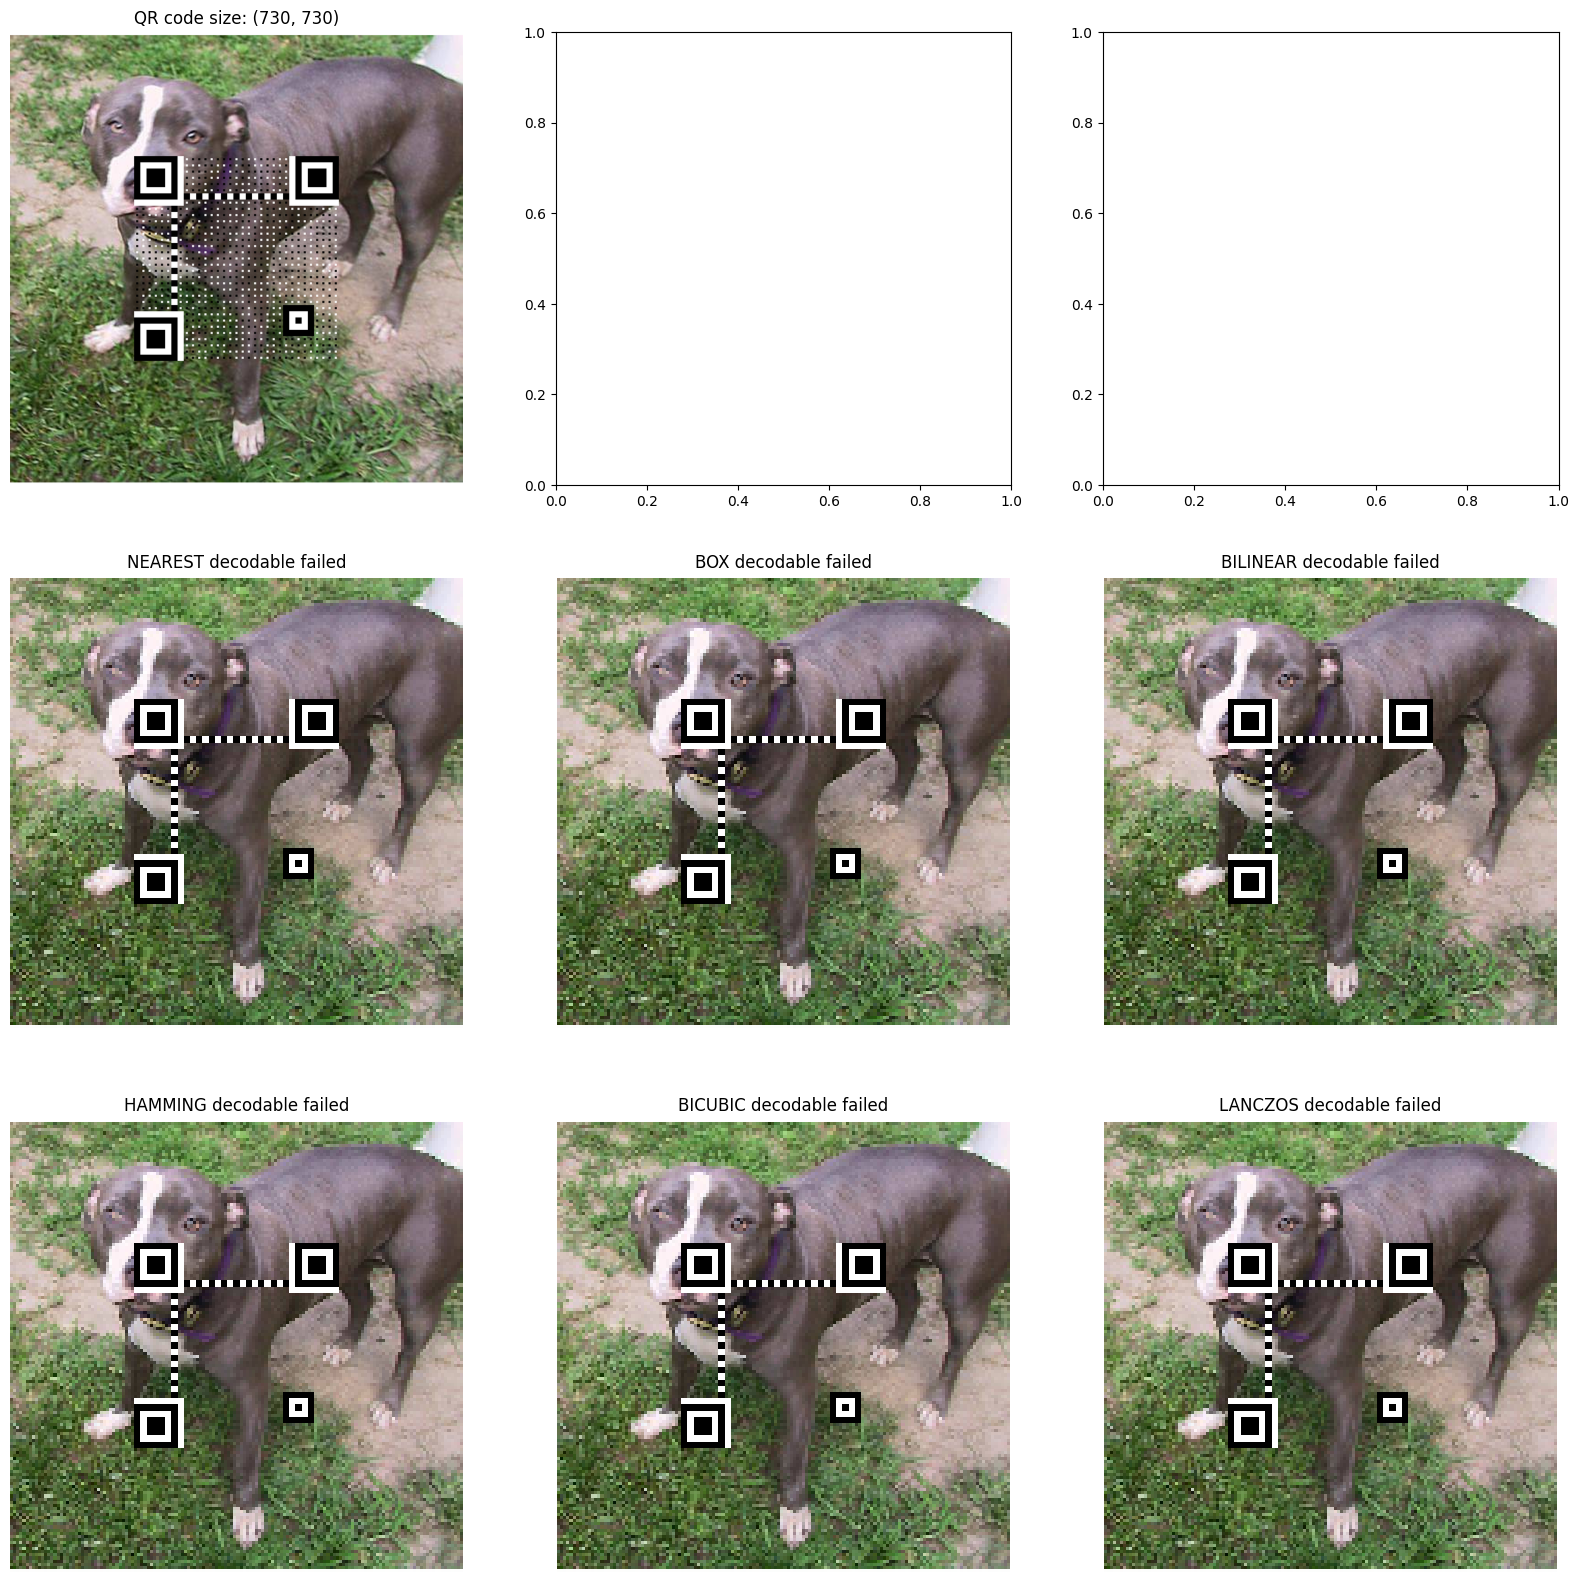

In [20]:
comp_types = [Resampling.NEAREST, Resampling.BOX, Resampling.BILINEAR, Resampling.HAMMING, Resampling.BICUBIC, Resampling.LANCZOS]
comp_names = ['NEAREST', 'BOX', 'BILINEAR', 'HAMMING', 'BICUBIC', 'LANCZOS']
flag = 'ENO'+''.join(random.choices(string.ascii_letters + string.digits + '\/=', k=48))
qr = create_qr_code(flag, 10, 20)
image = Image.open(io.BytesIO(qr))

plot, ax = plt.subplots(3, 3, figsize=(20, 20))
ax[0,0].imshow(image)
ax[0,0].axis('off')
ax[0,0].set_title('QR code size: '+str(image.size))
DOWNSCALE_FACTOR = 5
new_size = (image.size[0]//DOWNSCALE_FACTOR, image.size[1]//DOWNSCALE_FACTOR)
print(new_size)
for indx, c in enumerate(comp_types):
    image = image.resize(new_size, resample=c)
    decoded = "failed"
    try:
        decoded = read_qr_code(image)
    except:
        pass
    ax[(indx+3)//3, (indx+3)%3].imshow(image)
    ax[(indx+3)//3, (indx+3)%3].axis('off')
    ax[(indx+3)//3, (indx+3)%3].set_title(f"{comp_names[indx]} decodable {decoded}")
# image.show()
